In [149]:
import numpy as np
import matplotlib.pyplot as plt


In [150]:
I_0 = 1 #for simplicity and could be adapted with weights
eta = 376.7

def U_dipole(k,l,theta):
    U = (eta*k**2)/(32*np.pi**2)*(l**2)*np.sin(theta)**2
    return U

def U_standing_wave(k,l, theta):
    U = (eta)/(8*np.pi**2*np.sin(theta)**2)*(np.cos(np.cos(theta)*(k*l)/2)-np.cos((k*l)/2))**2
    return U

def U_half_wave(k, l, theta):
    k = 2*np.pi
    l= 1/2
    return U_standing_wave(k, l, theta)

def get_U(atype,k,l,theta):
    """
    1: dipole
    2: standing wave
    3: half wave
    """
    if atype == 1:
        return U_dipole(k,l,theta)
    elif atype == 2:
        return U_standing_wave(k,l,theta)
    elif atype == 3:
        return U_half_wave(k,l,theta)
    else:
        return None
    

In [151]:
def C_k(k,l, weights, positions, theta, phi):
    """
    k: wavenumber
    l: length of the antennas !in units of lambda!
    weights: list of each weight a_n
    positions: list of position of each antenna (x, y, z) !coordinates in units of lambda!
    """
    N = len(weights) #length of the array i.e number of element in the array
    k_x = k*np.sin(theta)*np.cos(phi)
    k_y = k*np.sin(theta)*np.sin(phi)
    k_z = k*np.cos(theta)
    wavelength = 2*np.pi/k
    C = 0
    for n in range(1, N):
        x = positions[n][0]*wavelength
        y = positions[n][1]*wavelength
        z = positions[n][2]*wavelength
        term1 = k_x*x
        term2 = k_y*y
        term3 = k_z*z
        C += weights[n]*np.exp(1j*(term1+term2+term3))
    return C

In [152]:
def convert_in_dB(U):
    return 10*np.log10(U)

In [153]:
def find_beamwidth(U, phi):
    """
    U must be normalized
    U: radiation intensity array taking values for each phi
    
    """
    #Normalize U in case
    U = U/np.max(U)
    intensity = U
    
    # Find -3 dB beamwidth (half-power points, i.e., intensity >= 0.5)
    threshold = 0.5
    above_threshold = np.where(intensity >= threshold)[0]
    
    if len(above_threshold) == 0:
        print("No beamwidth found, signal may be too weak or improperly defined.")
        return None, None
 
    
    # Find where there are gaps (non-continuous parts)
    diffs = np.diff(above_threshold)
    splits = np.where(diffs > 1)[0]  # Identify where the gaps are
    
    # If there are no gaps, the whole array is continuous
    if len(splits) == 0:
        beam_idx = above_threshold
    else:
        # Split into continuous segments and find the longest one
        blocks = np.split(above_threshold, splits + 1)
        beam_idx = min(blocks, key=len)
        
    
    # Find the angles corresponding to the continuous region
    phi_beam = phi[beam_idx]
    beamwidth_deg = np.degrees(phi_beam[-1] - phi_beam[0])
    
    return phi_beam[0],  phi_beam[-1], beamwidth_deg

In [154]:
def C_k(k,l, weights, positions, theta, phi):
    """
    k: wavenumber
    l: length of the antennas !in units of lambda!
    weights: list of each weight a_n
    positions: list of position of each antenna (x, y, z) !coordinates in units of lambda!
    """
    N = len(weights) #length of the array i.e number of element in the array
    k_x = k*np.sin(theta)*np.cos(phi)
    k_y = k*np.sin(theta)*np.sin(phi)
    k_z = k*np.cos(theta)
    wavelength = 2*np.pi/k
    C = 0
    for n in range(0, N):
        x = positions[n][0]*wavelength
        y = positions[n][1]*wavelength
        z = positions[n][2]*wavelength
        term1 = k_x*x
        term2 = k_y*y
        term3 = k_z*z
        C += weights[n]*np.exp(1j*(term1+term2+term3))
        
    
    return C

def power_gain(k,l, weights, positions, theta, phi, atype):
    """
    atype: antenna type(0: power gain only 1: dipole, 2: standing wave antenna, 3: half wave antenna)
    """
    C = C_k(k,l, weights, positions, theta, phi)
    C = abs(C)**2
    if atype != 0:
        U = get_U(atype,k,l,theta)
        C = U*C
    return C

def power_gain_dB(g):
    # convert to dB, clip at –40 dB, then normalize to [0,1]
    g_db = 10 * np.log10(np.clip(g, 1e-12, None))
    g_db = np.clip(g_db, -25, None)
    return (g_db + 25) / 25
def plot_powergain_2D(k, l, weights, positions, atype):
    theta = np.pi/2 
    phi = np.linspace(0, 2*np.pi, 801)
    g = power_gain(k, l, weights, positions, theta, phi, atype)
    g = g/np.max(g)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, g, linewidth=1)
    
    ax.set_title(f'Normalized Radiation Pattern')
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
    #Now in dB
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, power_gain_dB(g), linewidth=1)
    
    ax.set_title(f'Normalized Radiation Pattern (dB)')
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    
    ax.legend()
    plt.show()

C:\Users\yanis\AppData\Local\Temp\ipykernel_61376\3539824718.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


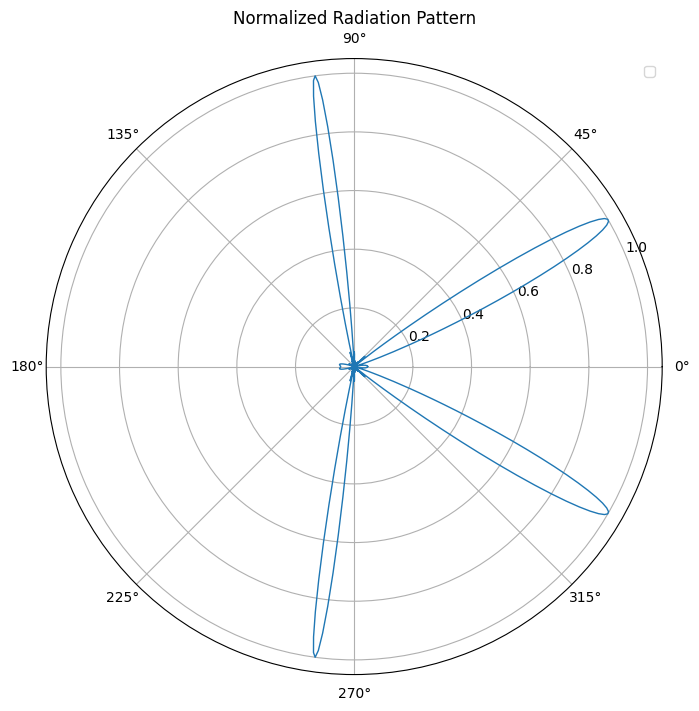

C:\Users\yanis\AppData\Local\Temp\ipykernel_61376\3539824718.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


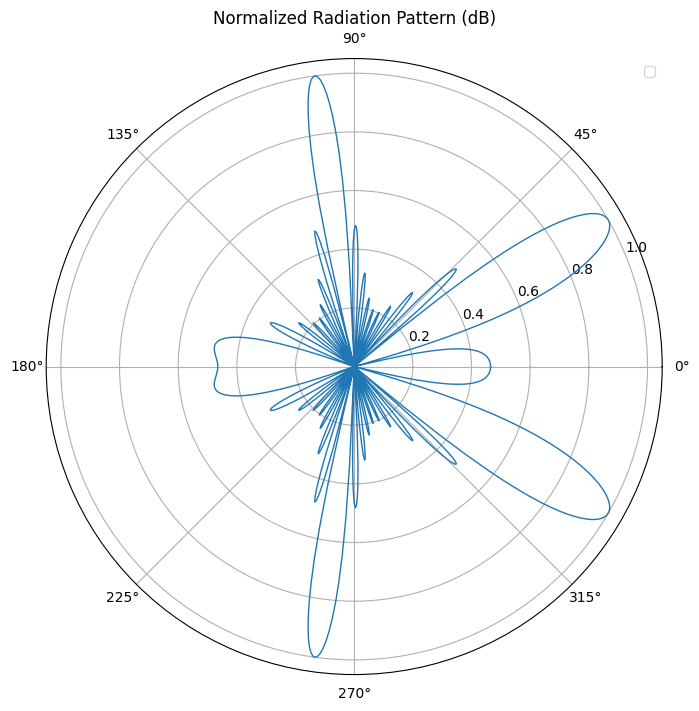

In [155]:
N = 10
d = 1
alpha = 30
alpha=alpha*np.pi/180
psi_shift=2*np.pi*d*np.cos(alpha)
z=np.exp(-1j*psi_shift)
weights = [z**n for n in range(N)] #example weights = [1]*N
positions = [(n*d, 0, 0) for n in range(N)]
k = 1
l= 1
plot_powergain_2D(k, l, weights, positions, 0)

VISIBLE REGION

In [156]:
def uniform_array_factor(psi, N):
    """
    Calculate array factor A(psi) for a uniform linear array with unit weights.
    
    Parameters:
        psi: phase difference between elements (radians)
        N: number of elements
    
    Returns:
        A: array factor (complex)
    """
    # Handle singularity at psi = 0 using limit value
    if np.isscalar(psi):
        if np.isclose(psi, 0):
            return N
        else:
            return np.sin(N * psi / 2) / np.sin(psi / 2)
    else:
        # Vectorized calculation for array input
        A = np.zeros_like(psi, dtype=complex)
        mask = ~np.isclose(psi, 0)
        A[mask] = np.sin(N * psi[mask] / 2) / np.sin(psi[mask] / 2)
        A[~mask] = N  # Set value at singularity
        return A

def plot_polar_array_factor(k, l, weight, spacing, atype, N, s='', psi_max=8):
    """
    Plot normalized array factor in polar coordinates as a function of psi.
    
    Parameters:
        k: wavenumber
        l: length of antennas (in units of lambda)
        weight: coefficient a_n
        spacing: distance between antennas (in units of lambda)
        atype: antenna type (1=dipole, 2=standing wave, 3=half-wave)
        N: number of antennas
        s: string to 'save' (or not) the figures
        psi_max: maximum value of psi to plot (radians)
    """
    # Create psi array (phase difference)
    psi = np.linspace(-psi_max, psi_max, 500)
    
    # Calculate array factor using uniform_array_factor
    A = uniform_array_factor(psi, N)
    A_norm = np.abs(A) / N  # Normalize by N
    
    # Get single element pattern (constant for this plot since we're focusing on array factor)
    U_single = np.ones_like(psi)
    
    # Calculate dB values
    A_dB = 20 * np.log10(A_norm + 1e-10)  # Add small value to avoid log(0)
    A_dB = np.clip(A_dB, -40, 0)  # Clip at -40 dB
    A_dB_norm = (A_dB + 40) / 40  # Normalize to [0,1] range
    
    # Find beamwidth in psi-space
    threshold = 1/np.sqrt(2)  # -3dB point
    
    # Find -3dB points on main lobe
    main_lobe_mask = np.abs(psi) < 2*np.pi/N  # Approximate region of main lobe
    main_lobe_indices = np.where(main_lobe_mask)[0]
    
    if len(main_lobe_indices) > 0:
        main_lobe_psi = psi[main_lobe_indices]
        main_lobe_A = A_norm[main_lobe_indices]
        
        # Find where array factor crosses threshold
        threshold_crossings = np.where(np.diff(main_lobe_A >= threshold))[0]
        
        if len(threshold_crossings) >= 2:
            left_idx = main_lobe_indices[threshold_crossings[0]]
            right_idx = main_lobe_indices[threshold_crossings[-1] + 1]
            
            # Interpolate for more accurate points
            left_psi = psi[left_idx] + (threshold - A_norm[left_idx]) * (psi[left_idx+1] - psi[left_idx]) / (A_norm[left_idx+1] - A_norm[left_idx])
            right_psi = psi[right_idx] + (threshold - A_norm[right_idx]) * (psi[right_idx+1] - psi[right_idx]) / (A_norm[right_idx+1] - A_norm[right_idx])
            
            beamwidth_psi = right_psi - left_psi
            beamwidth_deg = np.degrees(beamwidth_psi)
            
            # For display purposes
            half_power_points = [left_psi, right_psi]
            half_power_values = [threshold, threshold]
            show_beamwidth = True
        else:
            show_beamwidth = False
    else:
        show_beamwidth = False
    
    # LINEAR SCALE PLOT
    plt.figure(figsize=(12, 6))
    
    # Plot array factor
    plt.plot(psi, A_norm, linewidth=2, label=f'Array Factor (N={N})')
    
    # Define reference psi values with π, 2π, and 4π
    reference_psi = [np.pi, 2*np.pi, 4*np.pi, -np.pi, -2*np.pi, -4*np.pi]
    reference_labels = ["π", "2π", "4π", "-π", "-2π", "-4π"]
    reference_colors = ['g', 'b', 'purple', 'g', 'b', 'purple']
    
    # Add reference vertical lines at specific psi values with numerical values
    for i, (psi_val, label, color) in enumerate(zip(reference_psi, reference_labels, reference_colors)):
        if abs(psi_val) <= psi_max:
            plt.axvline(x=psi_val, color=color, linestyle='-', alpha=0.4)
            # Add numerical value next to the line, near the top of the plot
            plt.text(psi_val + 0.1, 1.0, f'{label} = {psi_val:.2f}', 
                    va='top', fontsize=10, backgroundcolor='white', alpha=0.7)
    
    # Add vertical lines at nulls (no text labels)
    for n in range(1, N):
        null_psi = 2 * n * np.pi / N
        if null_psi <= psi_max:
            plt.axvline(x=null_psi, color='r', linestyle='--', alpha=0.3)
            plt.axvline(x=-null_psi, color='r', linestyle='--', alpha=0.3)
    
    # Mark half-power points if available, but without annotations
    if show_beamwidth:
        plt.plot(half_power_points, half_power_values, 'ro', markersize=5)
        plt.plot(half_power_points, half_power_values, 'r-', linewidth=1.5)
    
    # Set labels and title
    plt.xlabel('$\psi$ (radians)', fontsize=12)
    plt.ylabel('Normalized Array Factor |A($\psi$)|/N', fontsize=12)
    plt.title(f'Gain in function of $\psi$', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(-psi_max, psi_max)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    
    # Save if requested
    if s == 'save':
        filename = f'ArrayFactor_psi_N_{N:.0f}_d_{spacing:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # DB SCALE PLOT
    plt.figure(figsize=(12, 6))
    
    # Plot array factor in dB
    plt.plot(psi, A_dB, linewidth=2, label=f'Array Factor (N={N})')
    
    # Add reference vertical lines at specific psi values with numerical values
    for i, (psi_val, label, color) in enumerate(zip(reference_psi, reference_labels, reference_colors)):
        if abs(psi_val) <= psi_max:
            plt.axvline(x=psi_val, color=color, linestyle='-', alpha=0.4)
            # Add numerical value next to the line
            plt.text(psi_val + 0.1, -5, f'{label} = {psi_val:.2f}', 
                    va='center', fontsize=10, backgroundcolor='white', alpha=0.7)
    
    # Add vertical lines at nulls
    for n in range(1, N):
        null_psi = 2 * n * np.pi / N
        if null_psi <= psi_max:
            plt.axvline(x=null_psi, color='r', linestyle='--', alpha=0.3)
            plt.axvline(x=-null_psi, color='r', linestyle='--', alpha=0.3)
    
    # Add -3dB horizontal line
    plt.axhline(y=-3, color='r', linestyle='--', label='-3 dB')
    
    # Set labels and title
    plt.xlabel('$\psi$ (radians)', fontsize=12)
    plt.ylabel('Normalized Array Factor (dB)', fontsize=12)
    plt.title(f'Gain in function of $\psi$', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(-psi_max, psi_max)
    plt.ylim(-40, 0)
    plt.legend(loc='upper right')
    
    # Save if requested
    if s == 'save':
        filename = f'ArrayFactor_psi_dB_N_{N:.0f}_d_{spacing:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Also show the relationship between phi and psi
    phi = np.linspace(0, 2*np.pi, 1000)
    theta = np.pi/2  # XY-plane
    psi_vs_phi = k * spacing * np.sin(theta) * np.cos(phi)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.degrees(phi), psi_vs_phi, linewidth=2)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Add horizontal lines for reference psi values with numerical values
    for psi_val, label, color in zip(reference_psi, reference_labels, reference_colors):
        if abs(psi_val) <= max(abs(psi_vs_phi)) + 0.5:  # Only show if within range
            plt.axhline(y=psi_val, color=color, linestyle='-', alpha=0.4)
            plt.text(355, psi_val + 0.1, f'{label} = {psi_val:.2f}', 
                    va='center', fontsize=10, backgroundcolor='white', alpha=0.7)
    
    plt.xlabel('phi (degrees)', fontsize=12)
    plt.ylabel('psi = kd*sin(theta)*cos(phi) (radians)', fontsize=12)
    plt.title(f'Relationship between phi and psi (k={k:.1f}, d={spacing}λ, θ=90°)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 360)
    plt.xticks(np.arange(0, 361, 45))
    
    # Save if requested
    if s == 'save':
        filename = f'psi_vs_phi_k_{k:.1f}_d_{spacing:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

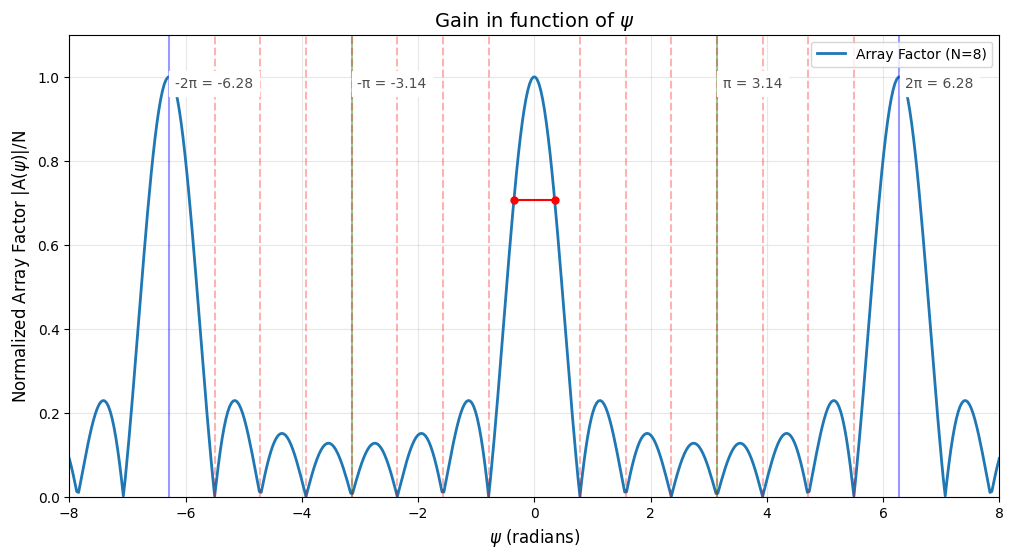

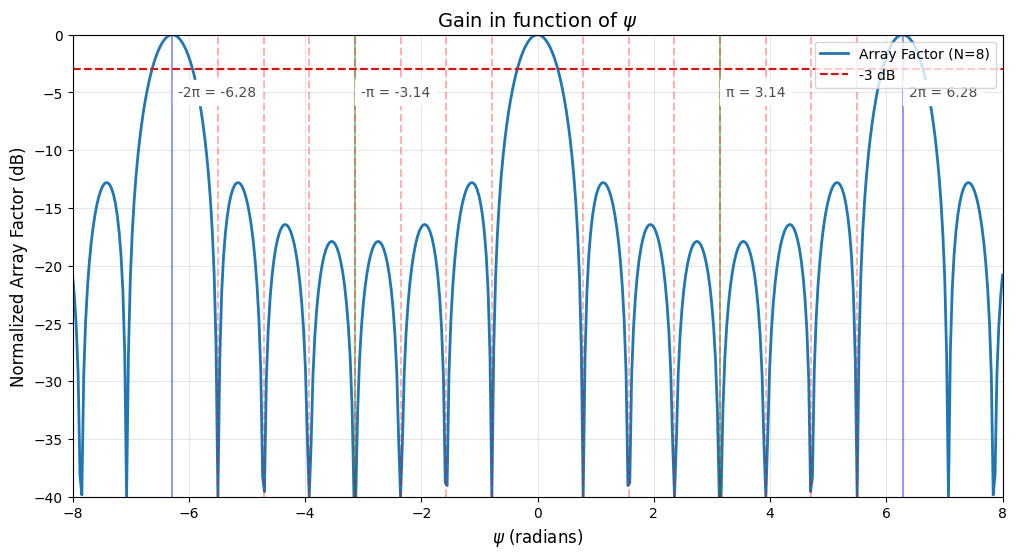

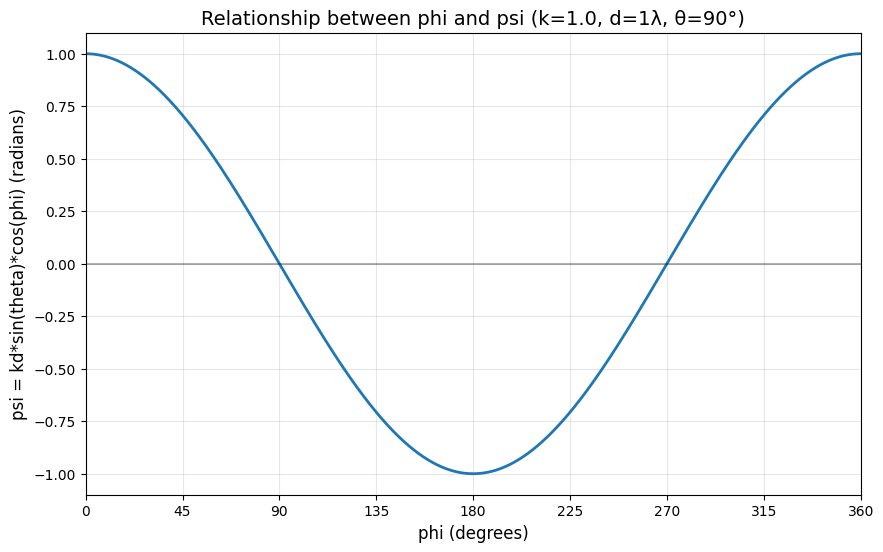

In [157]:
plot_polar_array_factor(1, 1, 1/2, 1, 1, 8)